##     Your   Name : Mahmoud Ahmed Shawqi
##     Intake [4] AI - ITI - Smart Village

In [72]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm
import matplotlib.pyplot as plt

## read csv

In [30]:
df = pd.read_csv('DailyTotalFemaleBirths.csv', parse_dates=["Date"], index_col="Date")
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [31]:
df.isna().sum()

Births    0
dtype: int64

In [32]:
print(df.shape)

(365, 1)


## plot data

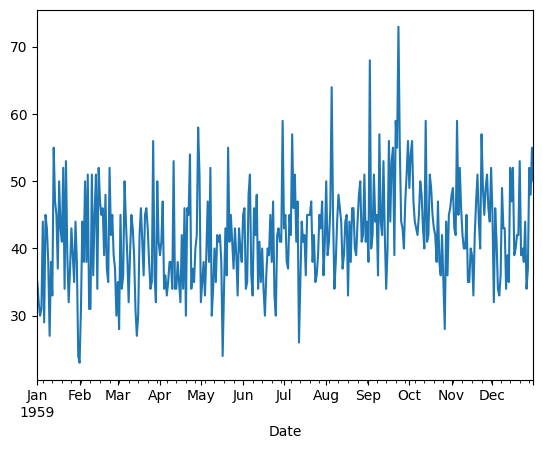

In [33]:
data = df['Births']
data.plot();

## check stationarity

In time series analysis, the assumption of stationary data refers to the idea that the statistical properties of a time series do not change over time. 

More specifically, a stationary time series is one in which the mean, variance, and autocorrelation structure are constant over time

In [34]:
result = adfuller(data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -4.808291253559765
p-value: 5.2434129901498554e-05
Critical Value (1%): -3.448748905151901
Critical Value (5%): -2.8696473721448728
Critical Value (10%): -2.5710891239349585


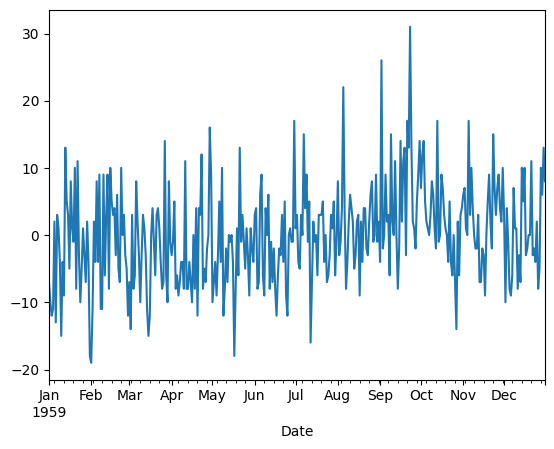

In [35]:
diff_data = data - data.mean()
diff_data.plot();

The ADF statistic is significantly lower than all critical values, suggesting strong evidence against the null hypothesis.

The p-value is very small, reinforcing the rejection of the null hypothesis.

Therefore, we can conclude that the time series data is `stationary`

## ACF

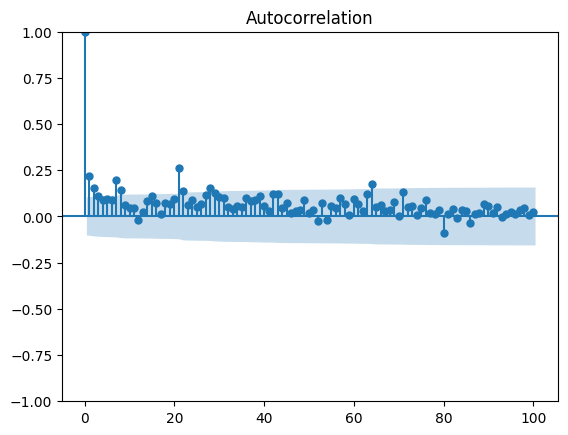

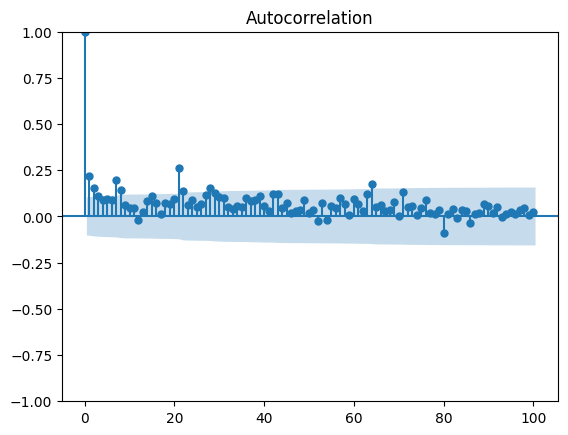

In [57]:
plot_acf(data, lags=100)

## Cut-off Pattern

## PACF

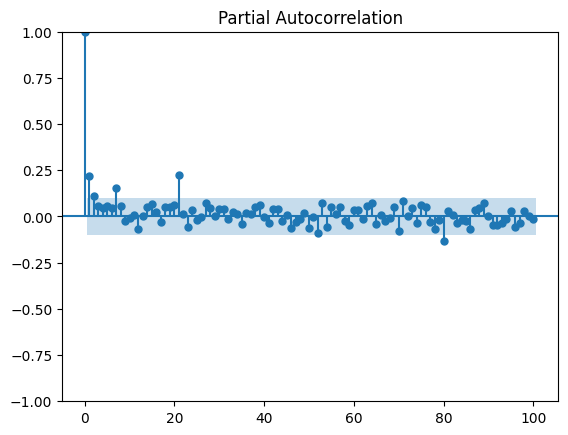

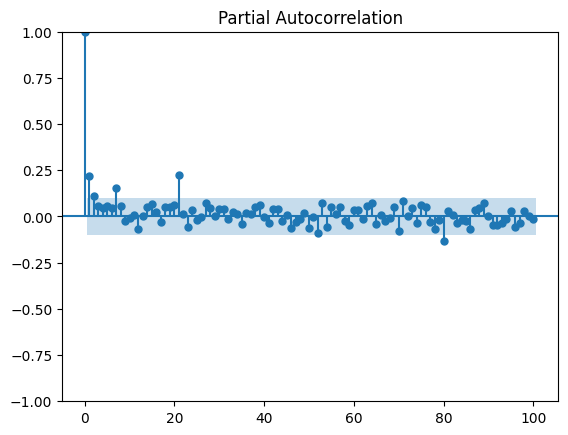

In [54]:
plot_pacf(data, lags=100)


## Cut-off Pattern

##  Applay decomposition and plot each component. 

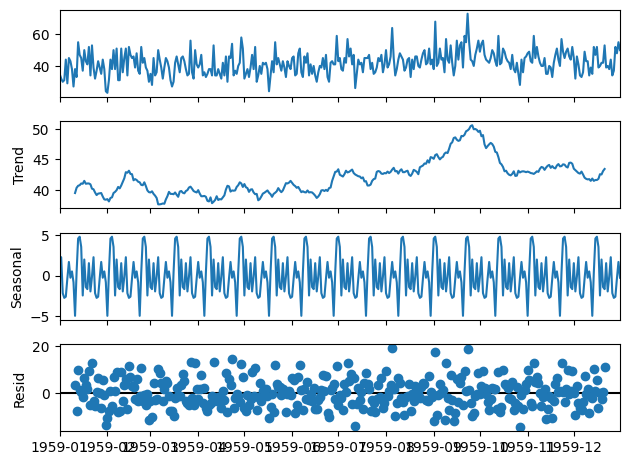

In [62]:
result = seasonal_decompose(df, model="additive", period=21)
result.plot();


## Apply the first difference and plot the data 

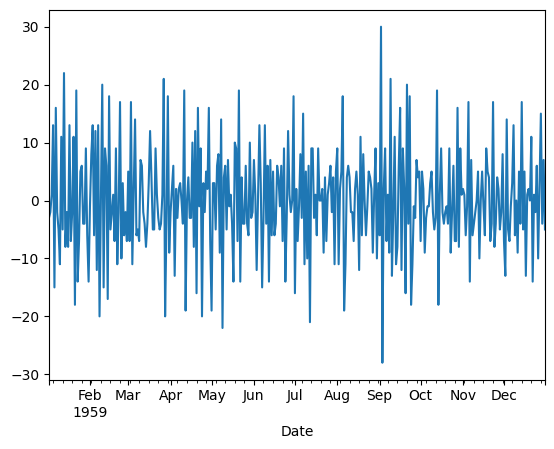

In [63]:
data_diff = data.diff().dropna()
data_diff.plot();

# split the data into 80% training and 20% testing.

In [111]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

Train size: 292
Test size: 73


In [67]:
test.head()

Date
1959-10-20    42
1959-10-21    38
1959-10-22    47
1959-10-23    38
1959-10-24    36
Name: Births, dtype: int64

## Applay 3 different ARIMA(AR,MA,ARMA,ARIMA,SARIMA) models, explain which model is best, and why.

In [105]:
order = (7,1,0)
seasonal_order = (1, 0, 1, 21)
model = ARIMA(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             Births   No. Observations:                  292
Model:             ARIMA(7, 1, 0)x(1, 0, [1], 21)   Log Likelihood                -981.538
Date:                            Fri, 14 Jun 2024   AIC                           1983.076
Time:                                    22:00:40   BIC                           2019.810
Sample:                                01-01-1959   HQIC                          1997.792
                                     - 10-19-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8297      0.062    -13.421      0.000      -0.951      -0.709
ar.L2         -0.6756      0.076   

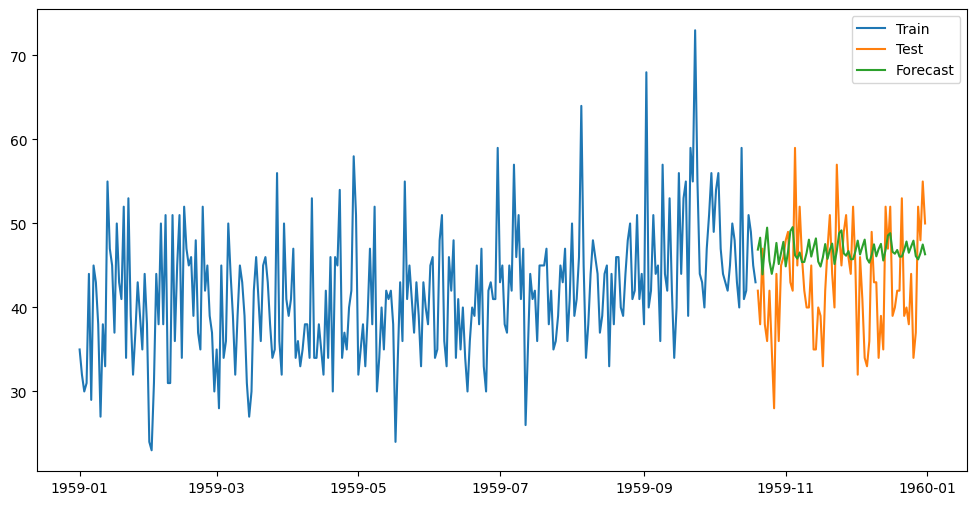

In [106]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.show()

# APPLAY support vector regressor to predict 1 step, 3 steps, and print MSE, MAE

In [121]:
def create_lagged_ts(data, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Births'].shift(lag)
    df.dropna(inplace=True)
    return df

In [122]:
lags = 3
lagged_df = create_lagged_ts(df, lags)

In [124]:
train_size = int(len(lagged_df) * 0.8)
train, test = lagged_df.iloc[:train_size], lagged_df.iloc[train_size:]

X_train, y_train = train.drop(columns=['Births']), train['Births']
X_test, y_test = test.drop(columns=['Births']), test['Births']

In [134]:
svr_model = SVR(kernel='linear', C=100, epsilon=0.1)
svr_model.fit(X_train, y_train)

SVR(C=100, kernel='linear')

In [135]:
y_pred_1 = svr_model.predict(X_test)

# Calculate metrics for 1-step ahead prediction
mse_1 = mean_squared_error(y_test, y_pred_1)
mae_1 = mean_absolute_error(y_test, y_pred_1)

print(f"1-step ahead prediction MSE: {mse_1}")
print(f"1-step ahead prediction MAE: {mae_1}")

1-step ahead prediction MSE: 39.92396086861786
1-step ahead prediction MAE: 4.997575801867383


In [137]:
def predict_n_steps_ahead(model, initial_data, n_steps):
    predictions = []
    current_input = initial_data.values.reshape(1, -1)
    
    for _ in range(n_steps):
        pred = model.predict(current_input)[0]
        predictions.append(pred)
        new_input = np.append(current_input[0, 1:], pred)
        current_input = new_input.reshape(1, -1)
        
    return predictions

In [138]:
X_test_3_steps = X_test.iloc[0]

# Predict 3 steps ahead for the first instance in the test set
y_pred_3_steps = predict_n_steps_ahead(svr_model, X_test_3_steps, 3)

# Evaluate 3-step prediction
y_test_3_steps = y_test.iloc[:3]
mse_3 = mean_squared_error(y_test_3_steps, y_pred_3_steps)
mae_3 = mean_absolute_error(y_test_3_steps, y_pred_3_steps)

print(f"3-step ahead prediction MSE: {mse_3}")
print(f"3-step ahead prediction MAE: {mae_3}")

3-step ahead prediction MSE: 12.318468443697796
3-step ahead prediction MAE: 2.8816343941302542


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


## Plot actual vs prediction

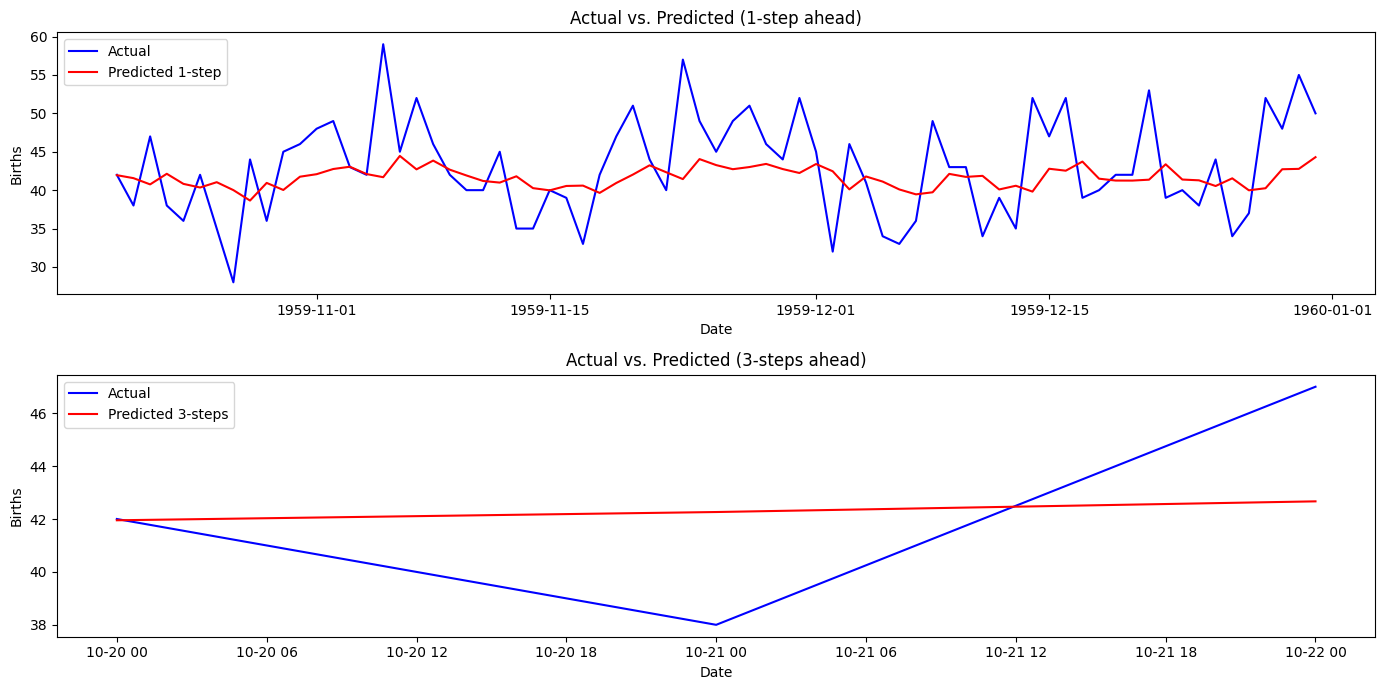

In [139]:
plt.figure(figsize=(14, 7))

# 1-step ahead prediction plot
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_1, label='Predicted 1-step', color='red')
plt.title('Actual vs. Predicted (1-step ahead)')
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()

# 3-steps ahead prediction plot (only plotting the first instance for demonstration)
plt.subplot(2, 1, 2)
plt.plot(y_test.index[:3], y_test.iloc[:3], label='Actual', color='blue')
plt.plot(y_test.index[:3], y_pred_3_steps, label='Predicted 3-steps', color='red')
plt.title('Actual vs. Predicted (3-steps ahead)')
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()

plt.tight_layout()
plt.show()


## applay LSTM or RNN to predict the next step and print MSE
## Plot actual vs. prediction

In [140]:
# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Create a function to reshape the data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print(f'Train Score: {train_score} RMSE')
print(f'Test Score: {test_score} RMSE')

# Plot baseline and predictions
plt.figure(figsize=(10, 6))
plt.plot(data.index, scaler.inverse_transform(data_scaled), label="Actual data")
plt.plot(train.index[look_back+1:], train_predict, label="Train prediction")
plt.plot(test.index[look_back+1:], test_predict, label="Test prediction")
plt.legend()
plt.show()

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.